In [3]:

import numpy as np 
import pandas as pd 

# cleaning the csv!
# getting the Timestamp and the Glucose Value (mg/DL)
df = pd.read_csv('Blood_glucose_visualization.csv', index_col=0)

glucose = df[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)']]


# drop the first 11 rows of weird non-integer things
glucose = glucose.drop([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


glucose.reset_index(drop=True, inplace=True)
glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'] = pd.to_datetime(glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'])

#renaming the timestamp to something easier to work with 
glucose = glucose.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)' : 'Timestamp'})


#writing a function to change str glucose to int values
def is_integer(val):
    try:
        # check if the float conversion of the value is equal to the integer conversion
        return int(val)
    except ValueError:
        return False
    
# Apply the function to make all glucose values integers
glucose['Glucose Value (mg/dL)'] = glucose['Glucose Value (mg/dL)'].apply(is_integer)

#making a column for indices
glucose['Index'] = glucose.index

glucose


,Timestamp,Glucose Value (mg/dL),Index
0,2024-04-05 00:05:57,79,0
1,2024-04-05 00:10:56,84,1
2,2024-04-05 00:15:57,88,2
3,2024-04-05 00:20:56,76,3
4,2024-04-05 00:25:57,76,4
...,...,...,...
25139,2024-07-03 16:13:16,144,25139
25140,2024-07-03 16:18:17,142,25140
25141,2024-07-03 16:23:16,141,25141
25142,2024-07-03 16:28:17,137,25142


In [4]:
type(glucose.iloc[0,1])
glucose.iloc[0,1]

79

<Axes: xlabel='Index', ylabel='Glucose Value (mg/dL)'>

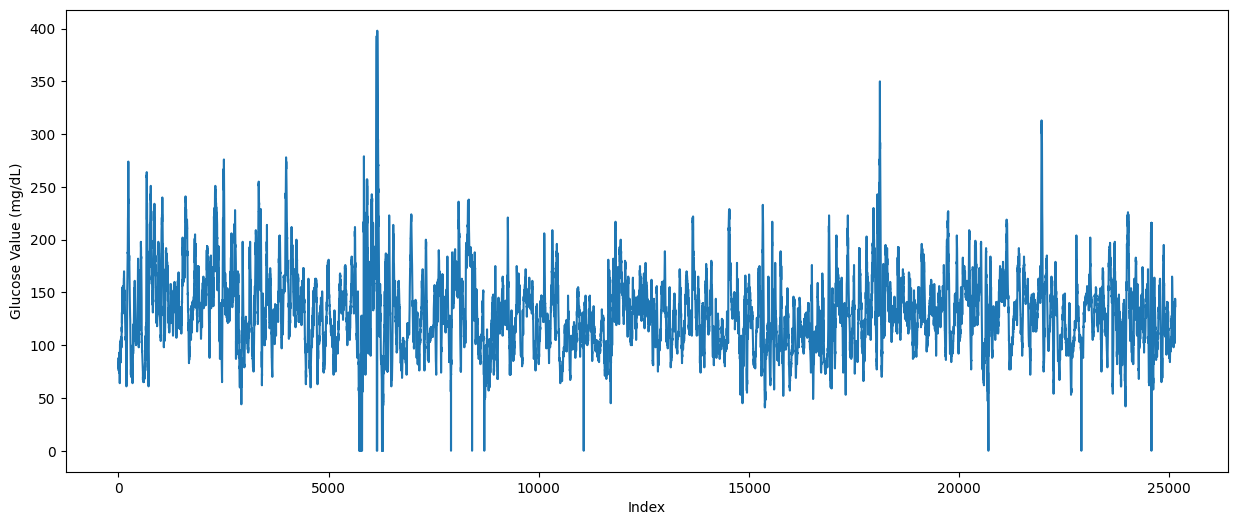

In [5]:
#plot the data as is and see the relationship between the index and the glucose value
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.lineplot(x="Index",y="Glucose Value (mg/dL)",  data=glucose)

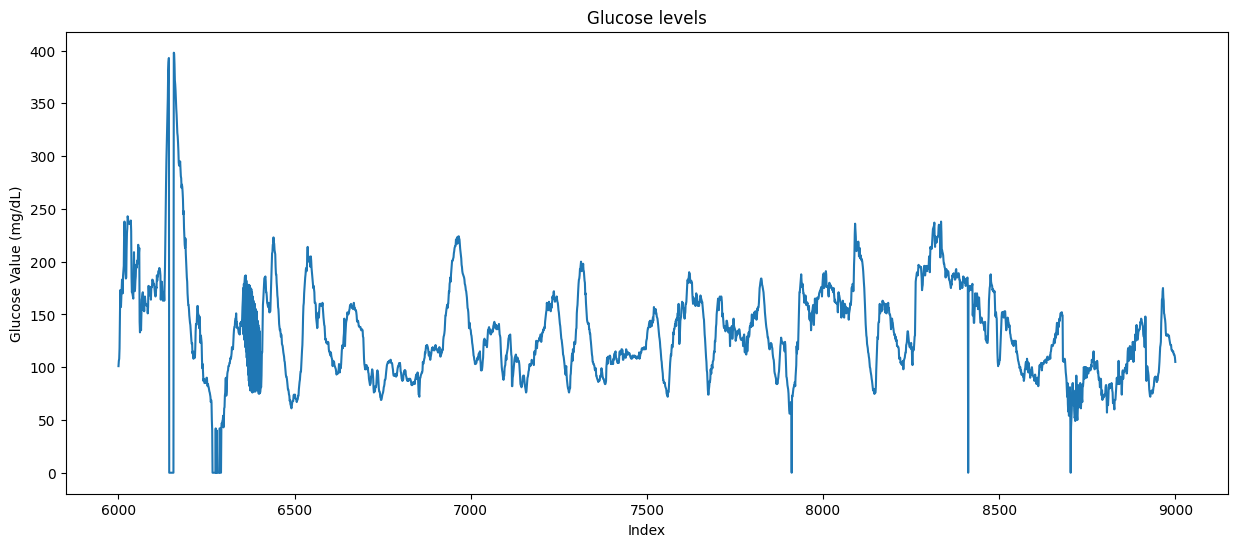

In [6]:
#make a function that takes in random indices and graphs only those portions
import seaborn as sns
import matplotlib.pyplot as plt

def graph_glucose(start,end):
    '''graphs a portion of the data between 2 integer index values'''

    if start < 0 or start>= end or end >len(glucose):
        print('error, enter correct values please')
        return
    

    mini_glucose = glucose.iloc[start:end+1]

    plt.figure(figsize=(15, 6))
    sns.lineplot(x="Index",y="Glucose Value (mg/dL)",  data=mini_glucose)

    #labeling

    plt.title('Glucose levels')
    plt.xlabel('Index')
    plt.ylabel('Glucose Value (mg/dL)')

graph_glucose(6000,9000)

In [ ]:
# some averages and statistics
# Target range for diabetics is between 70 and 180 mg/DL

glucose['Glucose Value (mg/dL)'].astype(int).describe().transpose()

# An average of 131 is not bad for a diabetic over a 90 day period
# but look at the Max, what happened there ?

count    25144.000000
mean       131.004096
std         36.612490
min          0.000000
25%        105.000000
50%        129.000000
75%        151.000000
max        398.000000
Name: Glucose Value (mg/dL), dtype: float64

In [ ]:

#TBR level 2 (very low): <54 mg/dL and <1%

#TBR level 1 (low): 54–69 mg/dL and <4%

#TIR: 70–180 mg/dL and >70%

#TAR level 1 (high): 181–250 mg/dL and <25%

#TAR level 2 (very high): >250 mg/dL and <5%

#adding ranges to the dataframe, so that for each glucose value, it is assigned a range

ranges = [0,55,70,180,250, 1000]

glucose.loc[:, 'ranges'] = pd.cut(glucose['Glucose Value (mg/dL)'], bins=ranges)

#glucose.head(60)

#learned about the 'Grouper' function capability from chatGPT when I prompted it with " how can I group files in a python timeseries data frame from a specific day all into one cluster"

#the starter pd.grouper with key part from gpt, but everything else from me!
result = (glucose.groupby([pd.Grouper(key="Timestamp", freq="D"), "ranges"], observed=False)["ranges"].count().unstack(0).T)


result




ranges,"(0, 55]","(55, 70]","(70, 180]","(180, 250]","(250, 1000]"
Timestamp,,,,,
2024-04-05,0,17,227,32,8
2024-04-06,0,4,269,15,0
2024-04-07,0,31,160,90,7
2024-04-08,0,0,192,96,0
2024-04-09,0,0,288,0,0
...,...,...,...,...,...
2024-06-29,12,19,207,50,0
2024-06-30,0,3,279,6,0
2024-07-01,0,19,240,29,0


Range < 55 0.51%
Range 55 < level < 70 1.69%
Target range 89.06%
Range 180 < level < 250 8.17%
Range > 250 0.57%


/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/1023017135.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


<Axes: title={'center': 'Distribution of Glucose ranges in Time Period'}, xlabel='Glucose Ranges', ylabel='Percent of data in range'>

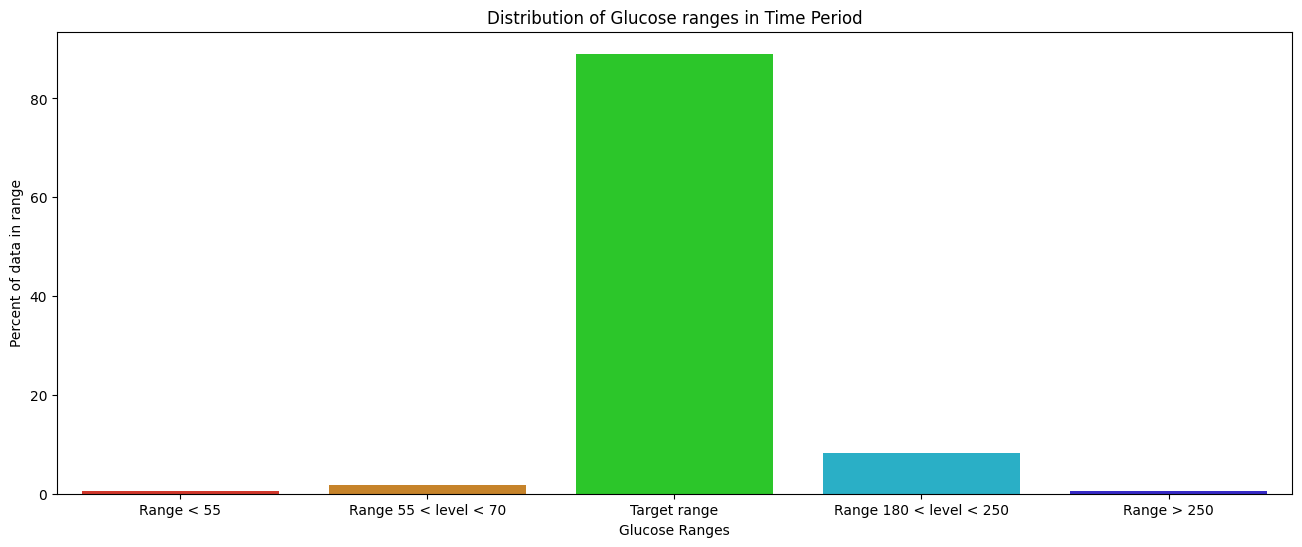

In [10]:
summed_results = result.sum()
very_low = 'Range < 55'
low = 'Range 55 < level < 70'
in_range = 'Target range'
high = 'Range 180 < level < 250'
very_high = 'Range > 250'
percent = '%'

#find the percentage for the whole dataset and round it to 2 places
print(f'{very_low} {str(round(summed_results.iloc[0]/summed_results.sum()*100,2))}{percent}')
print(f'{low} {str(round(summed_results.iloc[1]/summed_results.sum()*100,2))}{percent}')
print(f'{in_range} {str(round(summed_results.iloc[2]/summed_results.sum()*100,2))}{percent}')
print(f'{high} {str(round(summed_results.iloc[3]/summed_results.sum()*100,2))}{percent}')
print(f'{very_high} {str(round(summed_results.iloc[4]/summed_results.sum()*100,2))}{percent}')


#graphing this in a histogram
very_low_val = str(round(summed_results.iloc[0]/summed_results.sum()*100,2))
low_val = str(round(summed_results.iloc[1]/summed_results.sum()*100,2))
in_range_val = str(round(summed_results.iloc[2]/summed_results.sum()*100,2))
high_val = str(round(summed_results.iloc[3]/summed_results.sum()*100,2))
very_high_val = str(round(summed_results.iloc[4]/summed_results.sum()*100,2))

distributions = [float(very_low_val), float(low_val), float(in_range_val),float(high_val),float(very_high_val)]
ranges = [very_low, low, in_range, high, very_high]
df = pd.DataFrame({'Range': ranges, 'Distribution': distributions})

import seaborn as sns
import matplotlib.pyplot as plt

#function from prof dodds
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure(figsize=(20, 6))

plt.title('Distribution of Glucose ranges in Time Period')
plt.xlabel('Glucose Ranges')
plt.ylabel('Percent of data in range')
colors = ["#EB1F10", "#E08610", "#13E010", "#10C1E0", "#2110E0" ]

ax = plt.gca()
ax.set_aspect(0.02)

sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)

/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/1916307206.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


<Axes: title={'center': 'Distribution of Glucose ranges in Time Period'}, xlabel='Glucose Ranges', ylabel='Percent of data in range'>

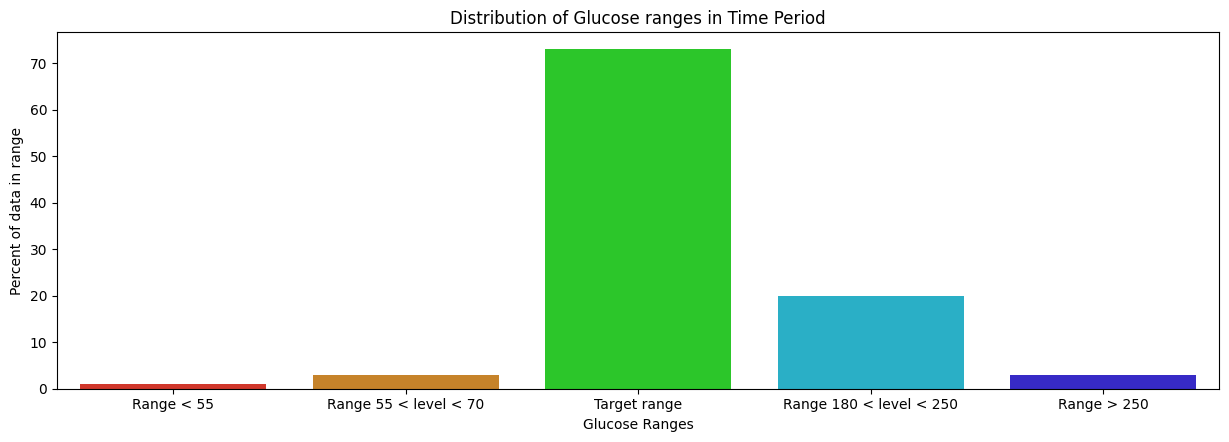

In [11]:
#A sample plot of the 'ideal' histogram

distributions = [1,3,73,20,3]
ranges = [very_low, low, in_range, high, very_high]
df = pd.DataFrame({'Range': ranges, 'Distribution': distributions})

import seaborn as sns
import matplotlib.pyplot as plt

#function from prof dodds
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure(figsize=(15, 6))

plt.title('Distribution of Glucose ranges in Time Period')
plt.xlabel('Glucose Ranges')
plt.ylabel('Percent of data in range')
colors = ["#EB1F10", "#E08610", "#13E010", "#10C1E0", "#2110E0" ]

ax = plt.gca()
ax.set_aspect(0.02)

sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)

Range < 55 4.62%
Range 55 < level < 70 4.88%
Target range 63.41%
Range 180 < level < 250 21.69%
Range > 250 5.39%


/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/4268813806.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


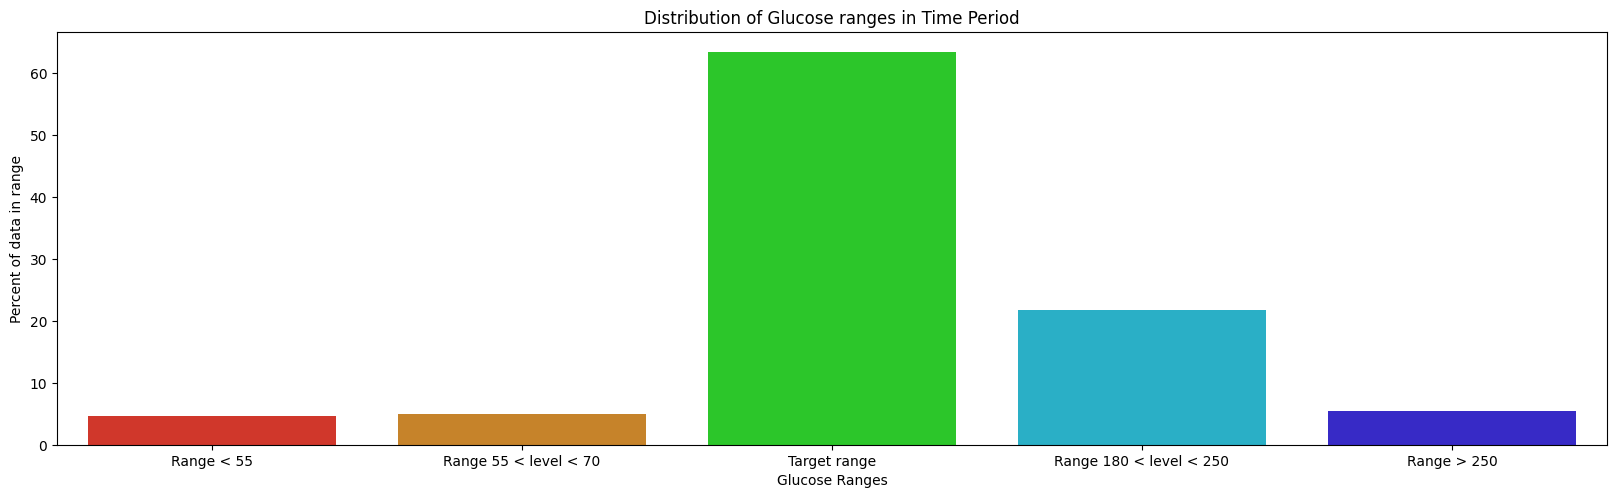

In [12]:
#now, we can have it changed based on indices that we input

summed_results = result.sum()
very_low = 'Range < 55'
low = 'Range 55 < level < 70'
in_range = 'Target range'
high = 'Range 180 < level < 250'
very_high = 'Range > 250'
percent = '%'


import seaborn as sns
import matplotlib.pyplot as plt

#function from prof dodds
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)


def hist_glucose(start,end):
    '''graphs a portion of the data between 2 integer index values'''

    if start < 0 or end >len(result): #start>= end: 
        print('error, enter correct values please')
        return
    
    range_sums = result.iloc[start:end+1].sum()


    print(f'{very_low} {str(round(range_sums.iloc[0]/range_sums.sum()*100,2))}{percent}')
    print(f'{low} {str(round(range_sums.iloc[1]/range_sums.sum()*100,2))}{percent}')
    print(f'{in_range} {str(round(range_sums.iloc[2]/range_sums.sum()*100,2))}{percent}')
    print(f'{high} {str(round(range_sums.iloc[3]/range_sums.sum()*100,2))}{percent}')
    print(f'{very_high} {str(round(range_sums.iloc[4]/range_sums.sum()*100,2))}{percent}')
    
    #graphing this in a histogram
    very_low_val = str(round(range_sums.iloc[0]/range_sums.sum()*100,2))
    low_val = str(round(range_sums.iloc[1]/range_sums.sum()*100,2))
    in_range_val = str(round(range_sums.iloc[2]/range_sums.sum()*100,2))
    high_val = str(round(range_sums.iloc[3]/range_sums.sum()*100,2))
    very_high_val = str(round(range_sums.iloc[4]/range_sums.sum()*100,2))


    distributions = [float(very_low_val), float(low_val), float(in_range_val),float(high_val),float(very_high_val)]
    ranges = [very_low, low, in_range, high, very_high]
    df = pd.DataFrame({'Range': ranges, 'Distribution': distributions})

    plt.figure(figsize=(20, 6))
    plt.title('Distribution of Glucose ranges in Time Period')
    plt.xlabel('Glucose Ranges')
    plt.ylabel('Percent of data in range')
    colors = ["#EB1F10", "#E08610", "#13E010", "#10C1E0", "#2110E0" ]

    ax = plt.gca()
    ax.set_aspect(0.02)

    sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)

hist_glucose(20,22)




In [ ]:
#voila instructions!
# 
# 
# In order to run the Jupyter notebook as a webapp first, install Voila
#Let us assume that the cgm_data_cleanse copy.ipynb is in a directory called cgm
# go to the ~/cgm ('cd ~' will take you to your home and then a 'cd cgm' will take you there in bash shell)
# python3 -m venv .venv
# from the ~/cgm directory activate the virtual enironment by executing 'source .venv/bin/activate'
# your prompt will change to ".venv) ~/cgm "
# your virtual env is active now (to deactivate, you can just type deactivate on the command prompt of bash shell)
#execute the following on the bash prompt
# pip install voila
# pip install --force-reinstall jupyter_client
# pip install ipykernel
#pip install pandas numpy ipywidgets matplotlib
#voila  cgm_data_cleanse.ipynb --port 8888

In [165]:
#For the demo, so that it is easier to see the points I want to highlight

#printing a lot of in between space


print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print('Output to separate presentation graphs from the code/testing')
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()


Range < 55 4.0%
Range 55 < level < 70 8.0%
Target range 88.0%
Range 180 < level < 250 0.0%
Range > 250 0.0%


/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/4268813806.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


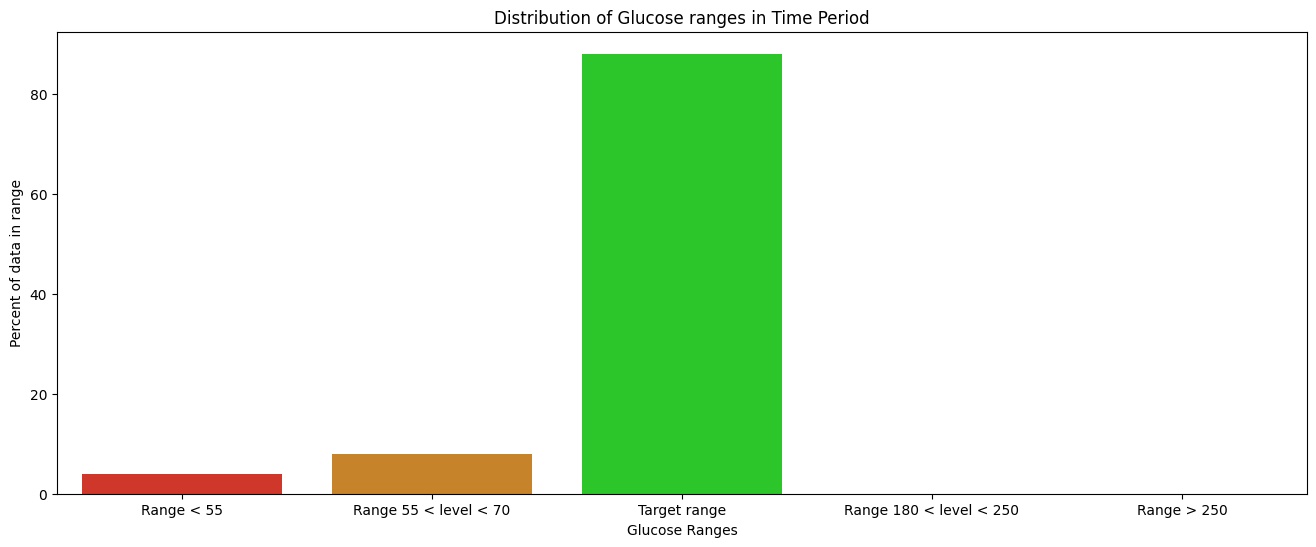

In [14]:
#Visualizing a single day


hist_glucose(30,30)

/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/3308769033.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


<Axes: title={'center': 'Distribution of Glucose ranges in Time Period'}, xlabel='Glucose Ranges', ylabel='Percent of data in range'>

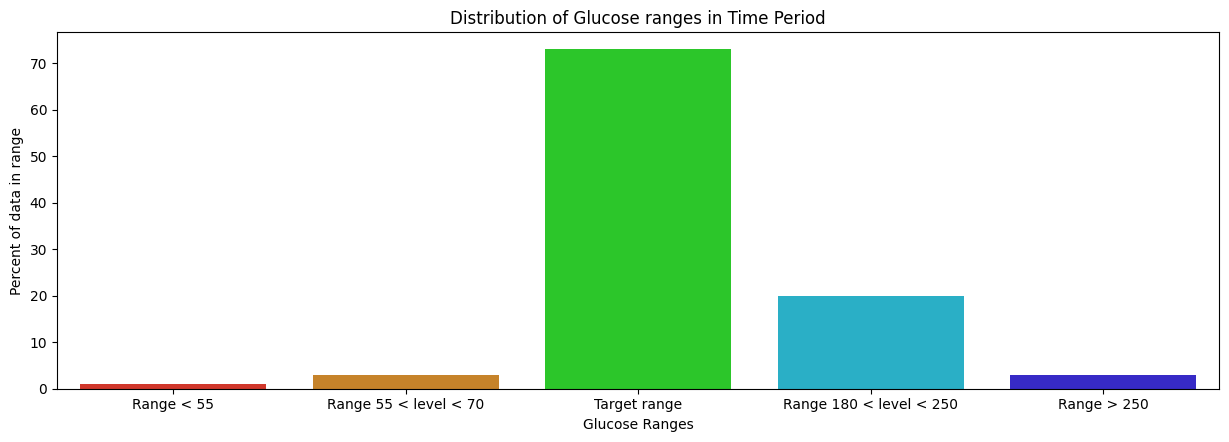

In [15]:
distributions = [1,3,73,20,3]
ranges = [very_low, low, in_range, high, very_high]
df = pd.DataFrame({'Range': ranges, 'Distribution': distributions})

import seaborn as sns
import matplotlib.pyplot as plt

#function from prof dodds
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure(figsize=(15, 6))

plt.title('Distribution of Glucose ranges in Time Period')
plt.xlabel('Glucose Ranges')
plt.ylabel('Percent of data in range')
colors = ["#EB1F10", "#E08610", "#13E010", "#10C1E0", "#2110E0" ]

ax = plt.gca()
ax.set_aspect(0.02)

sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)

amount < 55 0.51%
Range 55 < level < 70 1.69%
Amount in range 89.06%
Range 180 < level < 250 8.17%
Range > 250 0.57%


/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_17025/1024305193.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


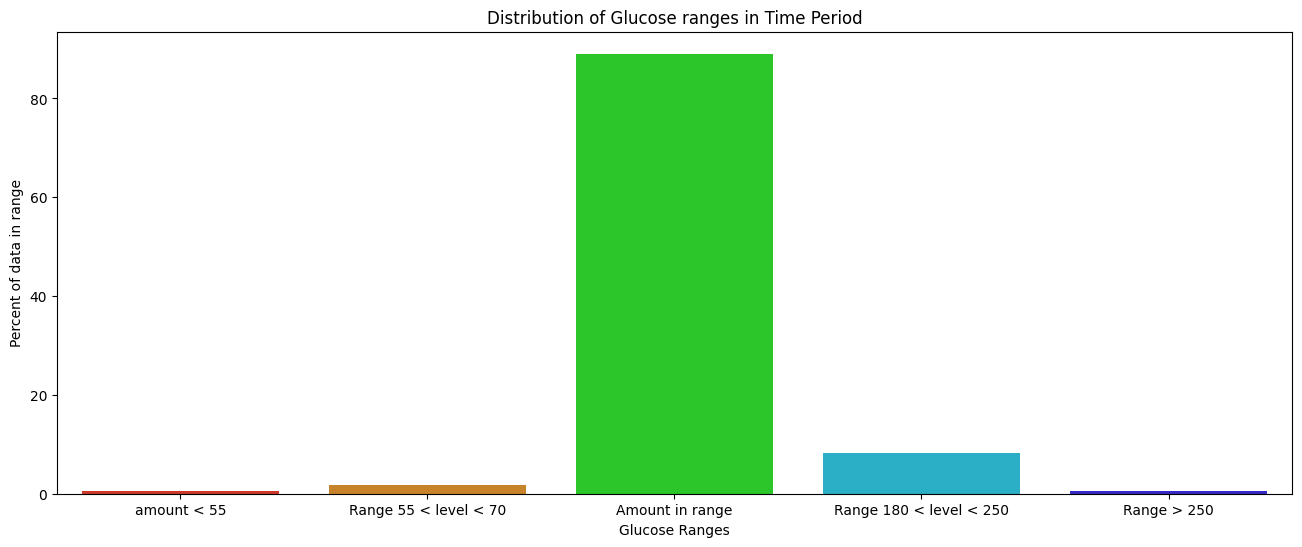

In [160]:
hist_glucose(0,90)

/var/folders/c8/z38nd50s7zn0lwymgz9hm7lm0000gn/T/ipykernel_79213/733419726.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)


<Axes: title={'center': 'Distribution of Glucose ranges in Time Period'}, xlabel='Glucose Ranges', ylabel='Percent of data in range'>

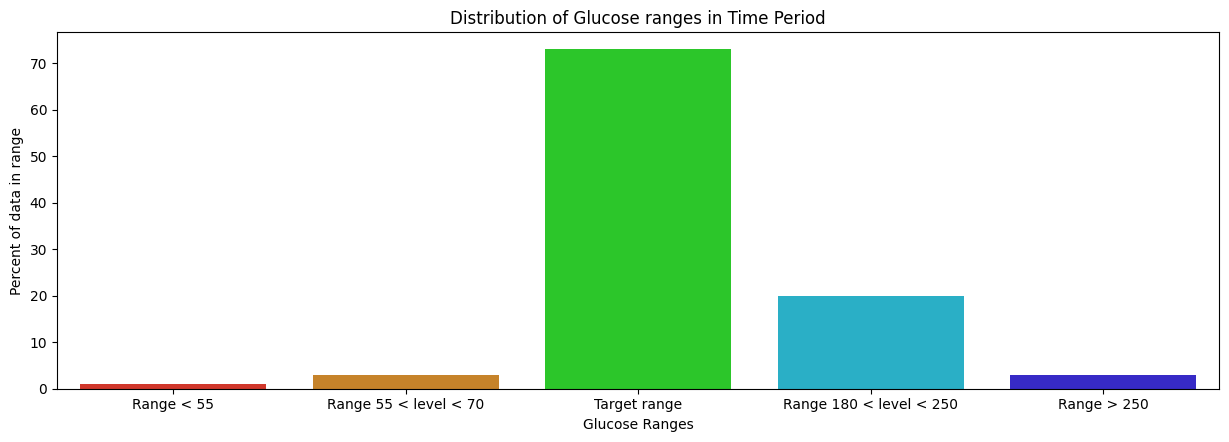

In [16]:
# the ideal graph again for comparison


distributions = [1,3,73,20,3]
ranges = [very_low, low, in_range, high, very_high]
df = pd.DataFrame({'Range': ranges, 'Distribution': distributions})

import seaborn as sns
import matplotlib.pyplot as plt

#function from prof dodds
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure(figsize=(15, 6))

plt.title('Distribution of Glucose ranges in Time Period')
plt.xlabel('Glucose Ranges')
plt.ylabel('Percent of data in range')
colors = ["#EB1F10", "#E08610", "#13E010", "#10C1E0", "#2110E0" ]

ax = plt.gca()
ax.set_aspect(0.02)

sns.barplot(data = df,x="Range", y="Distribution" , palette=colors)